<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

In [4]:
%load_ext rpy2.ipython
# remove this after running it once

<center>
<h1>Workshop 3: Genetic Association Studies</h1><br><br>
<i><big>Performing a quantitative trait genome-wide association study: from data preparation to analysis of results.</big><br><br>
Sophie Hackinger (sh29@sanger.ac.uk), Kostas Hatzikotoulas (kh9@sanger.ac.uk)</i>
</center>

## Objectives
In this workshop you will learn the basic skills needed to perform geneticassociation studies, from file format manipulation to filtering, single-point association and visualisation of results.
<br><br>

<figure>
  <img src="../materials/Workflow.jpg" width="80%" alt="" />
  <figcaption><i><center>Fig. 1: Workflow of the different analysis stages covered in the workshop</center></i></figcaption>
</figure>

<br>

We will be using <code>plink</code> to run the association and R to standardise our phenotype and visualise the results.
You can find a manual and command reference of <code>plink</code> [here](https://www.cog-genomics.org/plink/1.9/).

<br>

<div class="alert alert-warning">
<b>Location:</b> The data for this workshop can be found in this directory: <code>/data/Workshop3_geneticAssociation</code>

</div>


<hr>

## Step 1: File preparation

<br>
<div class="alert alert-warning">
<b>Location:</b> Input files for this step are located in the <code>Step1</code> folder.
</div>

<br>


### Missing phenotypes  


In large-scale sample collections you will often find that some individuals do not have a data entry for your phenotype of interest.

This is normally not a problem, as long as it doesn't affect too many samples. Association programs like <code>plink</code> and <code>SNPTEST</code> treat certain values (usually NA or -9) as missing phenotypes and exclude the corresponding samples automatically.

Nevertheless, it is good practice to check how many samples have missing phenotypes before running an association, and also make sure that their phenotype is set to an accepted missing value

<br>

<div class="alert alert-success"><b>Question 1:</b>  In the <code>Step1</code> folder you will find a file called <code>cohort1_pheno.txt</code> containing sample IDs and phenotype values. Using the command line, count the number of "NA" phenotypes.</div>


**Answer**:

```bash
awk '$2=="NA"{print}' ../data/cohort1_pheno.txt | wc -l

# alternatively, you can use grep
grep 'NA$' cohort1_pheno.txt | wc -l
```

### Phenotype cleaning and standardisation

When working with quantitative traits, such as height, BMI or blood lipids, you will often find that the measurements in your cohort do not follow a normal distribution. This could simply be due to the way your samples were collected - e.g. height follows an approximately normal distrbution at the population level; however, if you randomly pick 100 people, you might end up with a distribution skewed towards tall people, just by chance.
On the other hand, some traits naturally follow a non-normal distribution.

Since linear regression models rely on the assumption of a normally distributed response variable (the phenotype), it is important to inspect your phenotype measurements and, if necessary, standardise them before conducting a GWAS.

<br>

<div class="alert alert-success"><b>Question 2:</b>  Load the <code>cohort1_pheno.txt</code> file in R and look at the distribution of the phenotype values. How might you visualise this? Are there any outliers?</div>

<br>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show answer</button>

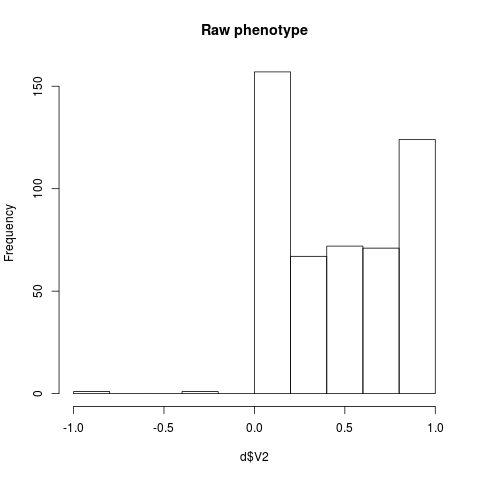

In [6]:
%%R
# ignore the above line!
setwd("../data/Workshop3_geneticAssociation/Step1")
library(data.table)

d=fread("cohort1_pheno.txt")
hist(d$V2, main="Raw phenotype")

From the plot you can see that there are outlier phenotype measurements in the negative range. We exclude these values as we know that it is not possible to have negative values for blood measurements. 
Depending on the type of trait you are looking at, you will have different criteria for outlier definition. For phsyiological or anthropometric measurements it is a good rule of thumb to look for negative values or ones that would be biologically impossible (for example, it's highly unlikely to find someone who is 900m tall!)

Next, we want to exclude the outliers from subsequent analyses and re-examine the phenotype distribution.

These steps can again be performed in R:

```
# set outliers to NA
d[V2<0,V2:=NA]

# re-examine distribution
hist(d$V2)
```


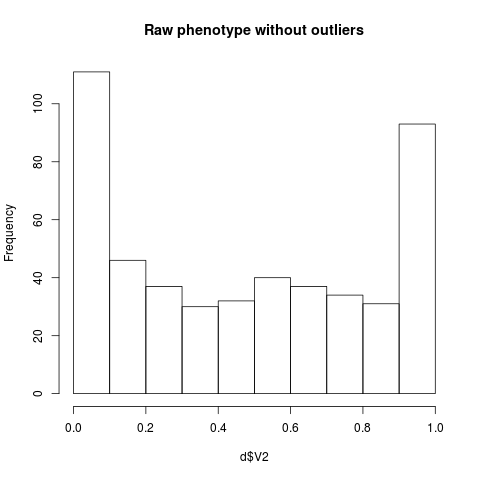

In [7]:
%%R

# set outliers to NA
d[V2<0,V2:=NA]

# re-examine distribution
hist(d$V2, main="Raw phenotype without outliers")


<br>

<div class="alert alert-success"><b>Question 3:</b>  What distribution does the phenotype follow? Can you come up with a way to transform this distribution to a standard normal one?</div>

<br>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show answer</button>

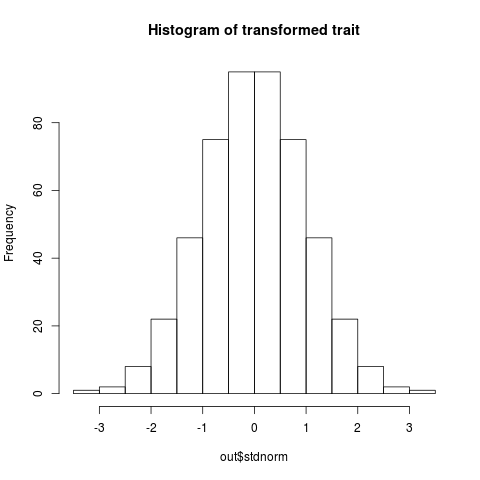

In [8]:
%%R

# first we want to record the order of samples (very important as many programs such as Plink or SNPTEST 
# match samples to genotypes by their order)
ord=d$V1

# then we exclude the NA samples from the transformation, but save them to add back in later
na=d[is.na(V2)]

# then we use an inverse-normal transformation to standardise our phenotype
c=3/8
d$stdnorm=qnorm((rank(d$V2)-c)/(nrow(d)-2*c+1))

# we add the NA samples back in
out=rbind(d[,.(V1,stdnorm)],na,use.names=F)

# sort samples IDs
out=out[match(ord,out$V1)]
# check that the order is correct
identical(out$V1,ord) 

# let's take a look at the transformed phenotype
hist(out$stdnorm, main="Histogram of transformed trait")

Inverse-normal transformations are one of the main ways to standardise non-normally distrubted phenotypes. More details on the formula used are summarised in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2921808/) paper. Setting <code>c</code> to 3/8 may seem arbitrary, and it kind of is. As discussed in the above paper under "Distinguishing among INTs", the choice of value for <code>c</code> makes very little to no difference, but 3/8 is most common.

Now that we have transformed our phenotype, we just need to save it to a <code>Plink</code> [compatible format](https://www.cog-genomics.org/plink/1.9/input#pheno). The <code>Plink</code> pheno file is similar to a .fam file, with the first two columns being individual and family IDs; the third column should contain the phenotype values.

```
write.table(d[,.(V1,V1,stdnorm)],"cohort1_pheno_final.txt",col.names=F,row.names=F,quote=F,sep="\t")
```

## Step 2: Analysis

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step2</code> folder.</div>


<div class="alert alert-success"><b>Question 4:</b> We want to perform genetic association in our cohort with our transformed phenotype stored in the <code>cohort1_pheno_final.txt</code> file. Run the association using <code>PLINK</code></div>


To run the association analysis we will use the QCed dataset from workshop 2 and the phenotype file we created above.

```
plink --bfile cohort1 --assoc --pheno ../Step1/cohort1_pheno_final.txt --out cohort1_assoc
```

This will produce an output file in the [`qassoc`](https://www.cog-genomics.org/plink2/formats#qassoc) format ("q" stands for quantitative, as our trait is not binary).

PLINK association reports are very well-readable by humans, but not so by other programs (mainly because Plink adds multiple spaces to display rows in an orderly fashion). Let's take some time to make our file more computer-friendly.

We want to remove multiple whitespace characters and convert the file to a tab-delimited format:
```bash
sed -i 's/ \+/\t/g' cohort1_assoc.qassoc
```

### Additional information

It is useful to add other columsn to the .qassoc file, such as alleles and allele frequencies. This is not only good for future reference, but also important for subsquent meta-analysis.

To get allele frequencies, we again run Plink:

```
plink --bfile cohort1 --freq --out cohort1_maf
```

This produces a [.frq](https://www.cog-genomics.org/plink/1.9/formats#frq) file. Similar to the .qassoc file, we want to remove redundant whitespace characters and change the delimiter to tabs.

```bash
sed -i 's/^ \+//g' cohort1_maf.frq
sed -i 's/ \+/\t/g' cohort1_maf.frq
```

**N.B.:** For Plink, "A1" is usually the minor allele and also set as the risk allele.

Next, we add this information to the association summary statisticsm together with the alleles, which we get from the .fam file.

```bash
join -1 2 -2 1 <(sort -k2,2 cohort1_assoc.qassoc) <(cut -f2,5,6 cohort1.bim | sort -k1,1) | sed -e 's/ \+/\t/g' > temp

cat <(echo -e "SNP CHR BP NMISS BETA SE R2 T P A1 A2 AF_A1") <(join -1 1 -2 1 <(sort -k1,1 temp) \
<(cut -f2,5 cohort1_maf.frq | sort -k1,1)) | sed -e 's/ \+/\t/g' > temp2

mv temp2 cohort1_assoc.qassoc
rm temp
```

<hr>


## Step 3: Visualisation of results

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step3</code> folder.</div>


Now that you have run the association, you will want to see whether there are any significant associations in your data.
There are two main plots generated after an association run:

* **The Quantile-Quantile (QQ)** plot is essentially a diagnostic plot. It compares the distribution of p-values against a uniform (expected) distribution. Any deviation from the expected is indicative of an issue (sample relatedness or overlap, non-normality of phenotype values, etc...). If the associaiton p-values are systematically lower (i.e. more significant)than expected, we refer to this as "inflation".
* **The Manhattan Plot** displays the $-log_{10}$ of the SNP p-values across the genome and allows to easily spot signals (peaks).


<br>

<div class="alert alert-success"><b>Question 4:</b>  In R, use the <code>fread</code> function from the <code>data.table</code> package to read the file. Plot a QQ-plot for the association p-values using <code>qqunif</code> from the <code>gap</code> package or <code>qq</code> from the <code>qqman</code> package.</div>


<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>

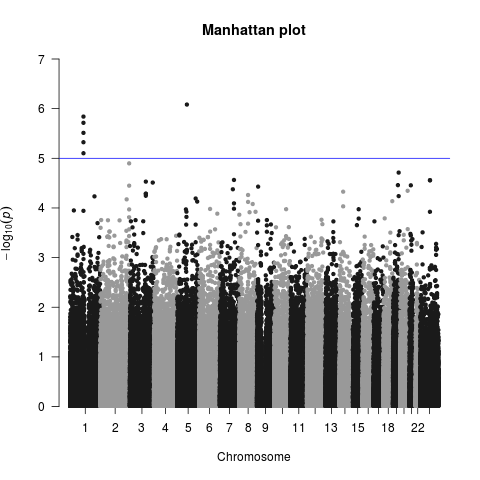

In [76]:
%%R
setwd("~sh29/repos/volos/WS3/Step3")
library(data.table)
library(qqman)
d=fread("cohort1_assoc.qassoc")
#d[,T:=NULL]
#qq(d$P)
manhattan(d,main="Manhattan plot")


The <code>qqman</code> package provides quick and useful functions to plot GWAS results. However, the code can be a bit clunky if you want to customise your plots. 

<br>

<div class="alert alert-success"><b>Bonus Question:</b>Try to create a Manhattan plot using only base graphics.</div>

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>

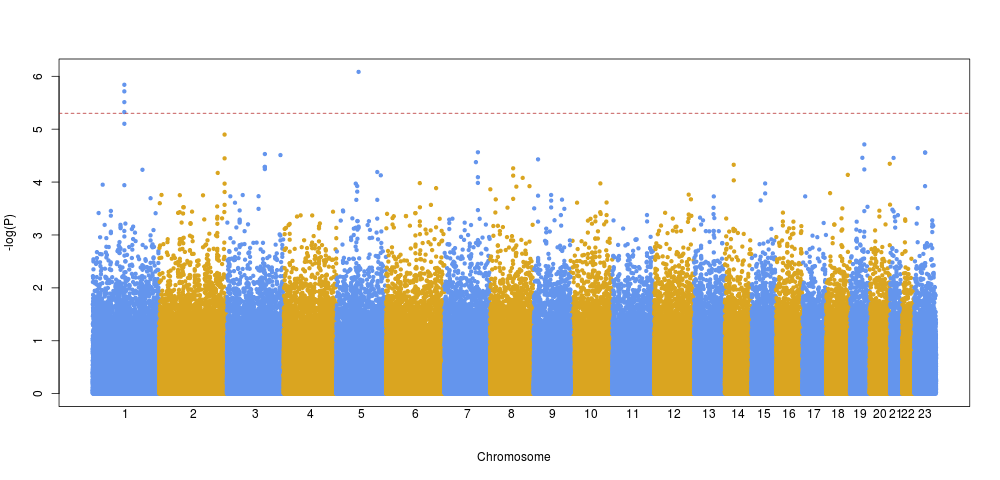

In [74]:
%%R -w 1000 ## ignore this line

#setwd("/nfs/users/nfs_s/sh29/Volos/")
d=fread("cohort1_assoc.qassoc")

## Define colors for each chromosome 
## (a list is available at www.stat.columbia.edu/~tzheng/files/Rcolor.pdf)
colors=c(rep(c("cornflowerblue", "goldenrod"),11),"cornflowerblue")

## We must create a column with continuous basepair positions from chr1 to chr23,
## otherwise we won't be able to plot one continuous x-axis
d[CHR==1,BP2:=rank(BP)]
pos=function(x) { rank(d[CHR==x]$BP)+max(d[CHR==(x-1)]$BP2) }
for(i in 2:23) {
    d[CHR==i, BP2:=pos(i)]
}

## Generate the plot
plot(x=d$BP2, y=-log(d$P, base=10), pch=20, col=colors[d$CHR], 
     ylab="-log(P)", xlab="Chromosome", xaxt="n")

## Add chromosome legends
ticks=unlist( lapply(1:23, function(x) median(d[CHR==x]$BP2)) )
mtext(seq(1,23), side=1, at=ticks)


## We draw lines at genome-wide and suggestive significance levels
abline(h=-log(5e-8, base=10), col="firebrick") # only shows if there are values that exceed that line on the y-axis
abline(h=-log(5e-6, base=10), col="firebrick", lty=2)

## Step 4: What are the peaks?

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step4</code> folder.</div>


From our Manhattan plot we can see that there are two loci reaching suggestive signifcance (p<5*10e-6), one on chromosome 1 and one on chromosome 5.

The next step is to investigate what these loci are. We'll go over different online tools to annotate and follow-up GWAS signals in workshop 4. For now, let's get a list of the top SNPs:

```bash
sort -g -k9,9 cohort1_assoc.qassoc | head
```